In [2]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import pandas as pd
from skimage import metrics
from tqdm import tqdm

In [3]:
images = mat73.loadmat(r'Datasets/VisualMapTest/images_CCW1Mesh_visualmap.mat')
data = mat73.loadmat(r'Datasets/VisualMapTest/data_CCW1Mesh_visualmap.mat')

In [4]:
noisy_images = images['noisy_images']
all_x = data['all_x']
all_y = data['all_y']
all_z = data['all_z']

xgrid = np.arange(-79,81,2)#-79:2:79;
ygrid = np.arange(-119,-59,2)#-119:2:-57;
zgrid = np.arange(-58,70,2)#-58:2:68;

In [5]:
noisy_images.shape

(32, 80, 64, 10)

In [6]:
all_x.shape

(38468,)

In [7]:
locations = np.array([all_x, all_y, all_z])
locations.shape

(3, 38468)

In [8]:
noisy_image = noisy_images[:,:,:, 4]
noisy_image.shape

(32, 80, 64)

In [9]:
xgrid

array([-79, -77, -75, -73, -71, -69, -67, -65, -63, -61, -59, -57, -55,
       -53, -51, -49, -47, -45, -43, -41, -39, -37, -35, -33, -31, -29,
       -27, -25, -23, -21, -19, -17, -15, -13, -11,  -9,  -7,  -5,  -3,
        -1,   1,   3,   5,   7,   9,  11,  13,  15,  17,  19,  21,  23,
        25,  27,  29,  31,  33,  35,  37,  39,  41,  43,  45,  47,  49,
        51,  53,  55,  57,  59,  61,  63,  65,  67,  69,  71,  73,  75,
        77,  79])

In [10]:
def coordToIndex(coord):
    return np.argwhere(ygrid==coord[1])[0][0], np.argwhere(xgrid==coord[0])[0][0], np.argwhere(zgrid==coord[2])[0][0]


def indexToCoord(index):
    if len(np.array(index).shape) == 2:
        return np.array([xgrid[index[:,1]], ygrid[index[:,0]], zgrid[index[:,2]]]).T
    else:
        return np.array([xgrid[index[1]], ygrid[index[0]], zgrid[index[2]]]).T

In [13]:
def LOCAscore(image, target_point):
    """
    Distance from the max value of the image to the target point
    :param image: 
    :param target_point: 
    :return: 
    """
    ind = np.unravel_index(np.argmax(image, axis=None), image.shape)
    image_point = indexToCoord(ind)
    localisation_error = np.linalg.norm(image_point - target_point)
    return localisation_error


def LOCA(processed_images, target_points):
    LOCAimage = np.zeros(processed_images[...,0].shape)
    for i in tqdm(range(processed_images.shape[3])):
        score = LOCAscore(processed_images[...,i], target_points[:,i])
        LOCAimage[coordToIndex(target_points[...,i])] = score
    return LOCAimage

In [14]:
thing = LOCA(noisy_images, locations)

100%|██████████| 10/10 [00:00<00:00, 673.39it/s]


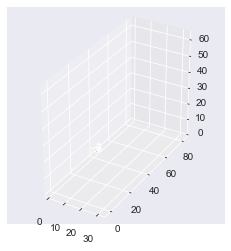

In [15]:
colors = np.empty(thing.shape, dtype='object')
colors[thing<np.quantile(thing[thing!=0], 0.25)] = 'purple'
colors[thing>np.quantile(thing[thing!=0], 0.25)] = 'blue'
colors[thing>np.quantile(thing[thing!=0], 0.5)] = 'green'
colors[thing>np.quantile(thing[thing!=0], 0.75)] = 'red'


ax = plt.figure().add_subplot(projection='3d')
ax.voxels(thing, facecolors=colors)
ax.set_aspect('equal')

plt.show()

In [16]:
def FWHMscore(image):
    """
    Maximum distance between the two nodes that are more than or equal to 50% of the max reconstruction
    :param image: 
    :return: 
    """
    image_max = np.max(image)
    image_max_idx = np.unravel_index(np.argmax(image, axis=None), image.shape)
    idxs = np.argwhere(image>image_max/2)
    score = 0
    for idx in idxs:
        newscore = np.max(np.linalg.norm(idxs - idx, axis=1)) * 2 #2mm voxels
        if newscore > score:
            score = newscore
    return score


def FWHM(processed_images, target_points):
    FWHM_image = np.zeros(processed_images[...,0].shape)
    for i in tqdm(range(processed_images.shape[3])):
        score = FWHMscore(processed_images[...,i])
        FWHM_image[coordToIndex(target_points[...,i])] = score
    return FWHM_image
    

In [17]:
FWHMscore(noisy_image)

22.44994432064365

In [18]:
thing = FWHM(noisy_images, locations)

100%|██████████| 10/10 [00:00<00:00, 144.66it/s]


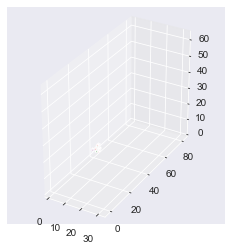

In [19]:
colors = np.empty(thing.shape, dtype='object')
colors[thing<np.quantile(thing[thing!=0], 0.25)] = 'purple'
colors[thing>np.quantile(thing[thing!=0], 0.25)] = 'blue'
colors[thing>np.quantile(thing[thing!=0], 0.5)] = 'green'
colors[thing>np.quantile(thing[thing!=0], 0.75)] = 'red'


ax = plt.figure().add_subplot(projection='3d')
ax.voxels(thing, facecolors=colors)
ax.set_aspect('equal')

plt.show()

In [20]:
def ERESscore(image, target_point):
    """
    Distance from the target point to the furthest value greater than 50% of the max value
    :param image: 
    :param target_point: 
    :return: 
    """
    image_max = np.max(image)
    idxs = np.argwhere(image>image_max/2)
    effective_resolution = np.max(np.linalg.norm(indexToCoord(idxs) - target_point, axis=1)) * 2
    return effective_resolution


def ERES(processed_images, target_points):
    ERES_image = np.zeros(processed_images[...,0].shape)
    for i in tqdm(range(processed_images.shape[3])):
        score = ERESscore(processed_images[...,i], target_points[:,i])
        ERES_image[coordToIndex(target_points[...,i])] = score
    return ERES_image

In [21]:
thing = ERES(noisy_images, locations)

100%|██████████| 10/10 [00:00<00:00, 1000.29it/s]


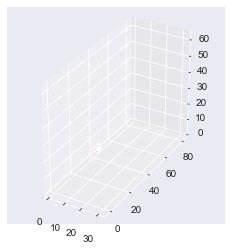

In [22]:
colors = np.empty(thing.shape, dtype='object')
colors[thing<np.quantile(thing[thing!=0], 0.25)] = 'purple'
colors[thing>np.quantile(thing[thing!=0], 0.25)] = 'blue'
colors[thing>np.quantile(thing[thing!=0], 0.5)] = 'green'
colors[thing>np.quantile(thing[thing!=0], 0.75)] = 'red'


ax = plt.figure().add_subplot(projection='3d')
ax.voxels(thing, facecolors=colors)
ax.set_aspect('equal')

plt.show()

## Testing

In [40]:
test_truth = np.zeros((10,10,10))
test_truth[2,2,2] = 1

In [41]:
LOCAscore(test_truth, indexToCoord([2,2,1]))

2.0

In [43]:
FWHMscore(test_truth)

0

In [45]:
ERESscore(test_truth, indexToCoord([2,2,3]))

4.0